# Should we care about money?
## A Deep Exploratory Data Analysis on Suicide Ratios
---
## Introduction
<p>
    The dataset was obtained on <a href="https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016">kaggle</a>.
 The description is as follows:
</p>
<p>
    <font color="darkslategray">
        <i>"This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum."<br></i>
    </font>
</p>

<p>
    I put a few comments on throughout the analysis to either clarify some points or give my opinion on a subject. Those are presented in blockquotes colored in dark blue. <br>
<blockquote>
    <font color="darkblue">This is a comment!</font>
</blockquote>
Feedback is extremly welcome. I hope you enjoy this work and can get some useful insight or piece of code from it.</p>

## Contents
    
![](https://i.imgur.com/j6UZtR5.png)
<br>

### Keywords:<br>
Python, EDA, Visualization, Tableau, Feature Engineering, Merging Datasets, Mental Health, World Data


I personally don't feel comfortable by presenting such an extense analysis without a short version of it. If you're somewhat like me you will think twice before going through this whole document.

## TLDR Version
This dataset contains information on suicide rates between 1985 and 2015 for 100 countries in the world. Year 2016 is included in the data but it is assumed to be incomplete. Not all countries are present in all years. It is divided in age groups and gender. I start analyzing changes over years and find a peak in 1995 which I later attribute to Russia's increasing suicides. 

I then group the countries into regions but found nothing of interest. In countries granularity I plot the top 10 for both extremes (low and high) for all years and more recently. While in the low end the top 10 didn't change a lot, the high suicide rates top 10 changed quite a bit for the last few years. 

I proceed analysing age groups and gender to find a pattern of higher number of suicides in males and older people. This varies for each country but it is an overall trend. I do not analyse generations.

On looking at GDP I plot its correlation with suicide rates for every country and find two different clusters of countries which I name low and high quadrants. Both have opposite correlations between SR and GDP. I discuss my personal opinion on that by the end of chapter 4.

I later add data on Religion and world temperature. The analysis suggests higher temperatures and a more religious country lowers suicide rates. 

In chapter 6 I provide an interactive dashboard to see how each country in the dataset is doing. Finally, in chapter 7, I present this work's conclusions.

---
---

# <b>1 - The Dataset</b>

## 1.1 - Introducing the Data
### General Information
- Original format: csv
- Dataset shape: 27820 x 12 (rows x columns)
- 19456 missing values for HDI

### Features in the dataset
#### <u>Categorical features</u>
**Country**: A total of 101 countries are included in this dataset. Most countries in Asia are not included and considering we have 195 countries in the world today, this is a quite biased data for worldwide analysis.<br>
**Year**: The dataset goes from 1985 to 2016<br>
**Sex**: Male/female differentiation<br>
**Age**: Age is divided in five age intervals.<br>
**Generation**: There are six generations included in this dataset. See 3.6 for details.
<br>
<blockquote>
    <p><font color="darkblue">This data's level of detail is defined by the combination of <b>Country+Year+Sex+Age</b>, which is a subsample of the population (e.g. Brazillian males of age between 15 and 25 in 1996). <br>For each of those we have corresponding numerical features.</font></p>
</blockquote>

#### <u>Numerical Features</u>
**Population size**: Number of people contained in each subsample
<br>**Number of Suicides**: Number of suicides in each subsample
<br>**Suicides per 100k people**: Number of suicides divided by the population size and multiplied by 100.000. This scales the number for better interpretation and allows you to make comparison between different subsamples.
<br>**GDP for year**: *Gross Domestic Product*, a measure of the market value for a country-year combination.
<br>**GDP per capita**: Obtained by dividing the GDP by the total population of the country for that year.
<br>**HDI for year** : *Human Development Index*, an index that measures life expectancy, income and education.
<br>

<hr/>

## 1.2 - Importing Libraries and Reading the Data

We need only the basic tools for an EDA for now.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')

In [2]:
original_dataset = pd.read_csv('../input/suicide-rates-overview-1985-to-2016/master.csv')
original_dataset.sample(5)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
3342,Belarus,2002,male,5-14 years,20,642277,3.11,Belarus2002,NaN,"14,594,249,023",1541,Millenials
27414,Uruguay,2003,male,35-54 years,107,383052,27.93,Uruguay2003,NaN,"12,045,631,093",3929,Boomers
16094,Malta,2008,female,5-14 years,0,22214,0.00,Malta2008,NaN,"8,977,149,553",23007,Generation Z
19215,Poland,2004,male,25-34 years,778,2866574,27.14,Poland2004,NaN,"255,102,252,843",7014,Generation X
6988,Cyprus,2007,female,75+ years,0,24362,0.00,Cyprus2007,NaN,"24,077,470,572",33048,Silent


I'll keep the original dataset as it is and create a new one to process the data throughout this analysis.<br>
The country-year column was probably used to join the suicide ratio data with the yearly data for each country. There is no need to drag it along this analysis so I'm dropping that as well.

In [3]:
# Creating a dataset copy
dataset = original_dataset.copy()

# Renaming a few columns to make interpretaion and coding easier
dataset.rename(columns={'suicides_no':'total_suicides',
                        'suicides/100k pop':'suicides_per_100k',
                        ' gdp_for_year ($) ':'gdp_for_year',
                        'gdp_per_capita ($)':'gdp_per_capita',
                        'HDI for year': 'HDI_for_year'}, inplace=True)

# Dropping country-year
dataset = dataset.drop('country-year', axis=1)

# Looks like our values for gdp per year are strings. Lets fix that.
dataset.gdp_for_year = dataset.gdp_for_year.apply(lambda x: float(''.join(x.split(','))))

<hr/>

# 2 - Exploratory Data Analysis

Now we will look at features and combinations of features

<blockquote>
<p><font color="darkblue"><b><i>Averaging the Averages</i></b><br>
I will use this opportunity to comment on a mistake I made and want to warn you about: <b>averaging the averages</b>. This is better understood with a simple example:<br>
Say you want to group your data into country. And for the sake of this example, we only have two groups in our country: <i>Young</i> and <i>Old</i>. <br>This imaginary country's data is presented in the table below.<br>

<table>
  <tr>
    <th>Group</th>
    <th>Populatio</th>
    <th>Suicides</th>
    <th>% of suicides</th>
  </tr>
  <tr>
    <td>Young</td>
    <td>100000</td>
    <td>10000</td>
    <td>10%</td>
  </tr>
  <tr>
    <td>Old</td>
    <td>1000</td>
    <td>500</td>
    <td>50%</td>
  </tr>
</table>

<br>In this example, if we simply did a <i>.groupby</i> on our country, our <i>Average % of suicides</i> would be <b>(10% + 50%) / 2</b>, which results in a % of suicides of <b>30%</b>
<br> However, if we want the % of suicides in this imaginary country, we should evaluate <b>(Sum of Suicides) / (Sum of Population)</b>, which results in <b>10,4%</b>.
<br>This is an extreme case to illustrate the difference. <b>None of them are wrong</b>, but it is important to calculate this understanding this difference to present your data properly.<font/><p/></blockquote>

---

## 2.1 - Years

Years is our time index. We will explore other features together with year to look for trends.<br>
The years range from 1985 to 2016. Let's take a look at both ends of our dataset.

In [4]:
agg_dict = {'country':'nunique', 'age':'nunique',
            'population':'sum',
            'total_suicides':'sum',
            'suicides_per_100k':'mean'}

both_ends = dataset.query('year < 1988 | year > 2013')

both_ends = both_ends[['year', 'country',
                       'age', 'population',
                       'total_suicides',
                       'suicides_per_100k']].groupby('year').agg(agg_dict)

both_ends.rename(columns={'country':'Distinct Countries', 'age':'Age groups',
                          'population':'Sum of Population', 'total_suicides':'Sum of Suicides',
                          'suicides_per_100k':'Avg Suicides Ratio per 100k'}, inplace=True)

both_ends['Calculated Suicide Ratio'] = 1e5 * both_ends['Sum of Suicides'] / both_ends['Sum of Population']

both_ends

,Distinct Countries,Age groups,Sum of Population,Sum of Suicides,Avg Suicides Ratio per 100k,Calculated Suicide Ratio
year,,,,,,
1985,48,6,1008600086,116063,11.826198,11.507336
1986,48,6,1029909613,120670,11.423333,11.716562
1987,54,6,1095029726,126842,11.644213,11.583430
2014,78,6,1912057309,222984,11.011464,11.661994
2015,62,6,1774657932,203640,11.094073,11.474887
2016,16,5,132101896,15603,13.421188,11.811337


**Insights from this table:**
- We can see that the data from 2016 **only has 16 countries** and actually **does not include an age group (4~15 years)**. We just have to be sure we dont use these data to mess with the rest of the analysis. A trend can be totally misinterpreted including that last year;
- We also notice that the number of countries in the data vary each year. We will explore more on that on the Country analysis;

In [5]:
# Removing the year 2016 from our processed dataset
dataset = dataset.query('year != 2016')

#### Yearly changes

Now we will generate some yearly data and plot it. 

<blockquote>
    <p>
        <font color="darkblue">In this chapter we are looking at <i>'Worldwide'</i> (less than half of countries in the world) data to analyse *suicide ratios*. <br>Before we continue with our analysis there are <u>a few things I would like to point out:</u>
        <ol>
            <li>As I said just above, our *'world'* is very limited. Until we have data for all countries, I will be very skeptic on world trends here.</li>
            <li>We are analysing *suicide*, which is a topic <u><b>extremly related to social and cultural aspects</b></u>. There might exist a correlation between countries, but hardly a causation. (e.g. suicides in Japan and in Brazil probably have different main causes). Later on I will focus on country-specific analysis. </li>
        </ol>
        </font>
    </p>
</blockquote>

In [6]:
agg_dict = {'country':'nunique', 'population':'sum', 'total_suicides':'sum'}
yearly_data = dataset[['year', 'country', 
                       'population',
                       'total_suicides']].groupby('year', as_index=False).agg(agg_dict)

yearly_data.rename(columns={'population':'Population',
                            'total_suicides':'Total Suicides'}, inplace=True)
yearly_data['Suicides by 100k people'] = 100000 * yearly_data['Total Suicides'] / ( yearly_data['Population'] )

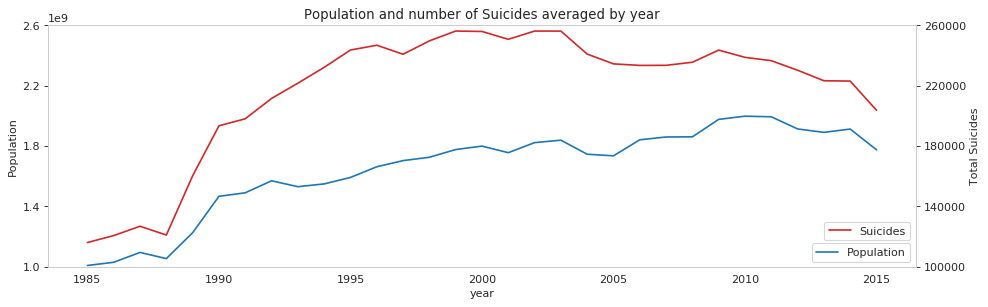

In [7]:
fig, ax1 = plt.subplots(1,1,figsize=(14,4), dpi=80, sharey=False)

sns.lineplot(data=yearly_data, y='Population', x='year', ax=ax1, label='Population')
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1, 0.12))
ax1.set_yticks([1e9, 1.4e9, 1.8e9, 2.2e9, 2.6e9]);
ax1.set_ylim(1e9, 2.6e9)

ax2 = plt.twinx()
sns.lineplot(data=yearly_data, y='Total Suicides', x='year', ax=ax2, color='C3', label='Suicides')
ax2.grid(False)
ax2.set_ylim(1e5, 2.6e5)
ax2.set_yticks([1e5, 1.4e5, 1.8e5, 2.2e5, 2.6e5]);
ax2.legend(bbox_to_anchor=(1, 0.21))

plt.title('Population and number of Suicides averaged by year');

**Two things to point out:**
- We can't capture any information on suicides here because its change is being dragged by the changes in population.
- The population having such a high variance is due to the changes in number of countries included in each year. Later on we will look on a few specific countries.

In [8]:
# Defining this because I will use it quite often to make the plots somewhat standard

def standard_plot(title=None, x=None, y=None):
    
    fig, ax = plt.subplots(figsize=(12,4), dpi=80)
    
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(14)
   
    if title != None:
        ax.set_title(title)
        ax.title.set_fontsize(15)
        
    if x != None:
        ax.set_xlabel(x)
        
    if y != None:
        ax.set_ylabel(y)
          
    return fig, ax

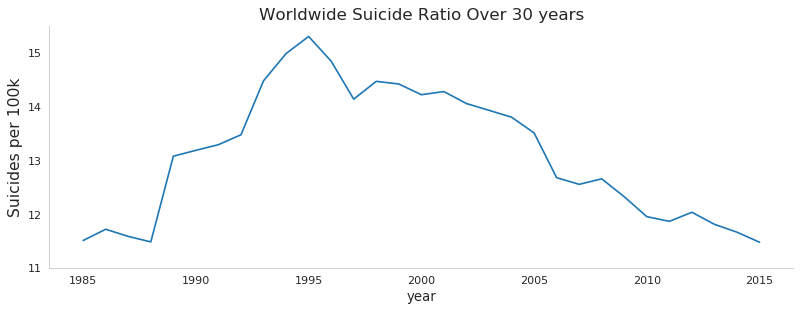

In [9]:
fig, ax = standard_plot('Worldwide Suicide Ratio Over 30 years',
                        y='Suicides per 100k', x='Years')
yearly_data.plot(kind='line', x='year', y='Suicides by 100k people', ax=ax, legend=False, grid=False)
ax.set_yticks([11, 12, 13, 14, 15]);

There is a clear **peak in 1995** and a decrease after it. We will later dive into it on a future section. Beyond that, there is not much else to tell from this graph.
<br>Lets explore the other features now.

---

## 2.2 - Regions

### Countries Lookup Data

Our data does not come with region information for each country. Instead of doing it manually, we can get a country 'Metadata' file from WorldBank. <br>Just download any indicator and it will come with both an indicator metadata and a country metadata file.
<br>
Source: http://www.worldbank.org/
<br><br>
This metadata contains information on the region. Now all we need to do is join both datasets.

In [10]:
countries_lookup = pd.read_csv('../input/countries-lookup/countries_lookup.csv')
countries_lookup.head(3)

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,Central Bureau of Statistics and Central Bank ...,Aruba,NaN
1,AFG,South Asia,Low income,Central Statistics Organization; World Bank st...,Afghanistan,NaN
2,AGO,Sub-Saharan Africa,Lower middle income,IMF ; Source of population estimates: UN Popul...,Angola,NaN


In [11]:
dataset = dataset.merge(countries_lookup[['TableName', 'Country Code', 'Region']],
                        how='left',
                        left_on='country',
                        right_on='TableName').drop('TableName', axis=1)

A few countries were named different in the look_up data but we can manually fix it.

I will also do another change by separating Latin America to South America, Central America and Caribbean. Again, doing it manually. 

I guess this could also be done with some other regions but I chose to only do it on my home continent because I am more familiarized with it.

In [12]:
dataset.loc[dataset["country"] == 'Republic of Korea', 'Region'] = 'East Asia & Pacific'
dataset.loc[dataset["country"] == 'Saint Lucia', 'Region'] = 'Latin America & Caribbean'
dataset.loc[dataset["country"] == 'Kyrgyzstan', 'Region'] = 'Europe & Central Asia'
dataset.loc[dataset["country"] == 'Bahamas', 'Region'] = 'North America'
dataset.loc[dataset["country"] == 'Slovakia', 'Region'] = 'Europe & Central Asia'
dataset.loc[dataset["country"] == 'Saint Kitts and Nevis', 'Region'] = 'Latin America & Caribbean'
dataset.loc[dataset["country"] == 'Macau', 'Region'] = 'East Asia & Pacific'
dataset.loc[dataset["country"] == 'Saint Vincent and Grenadines', 'Region'] = 'Latin America & Caribbean'

In [13]:
s_a_countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
                'Guyana', 'Paraguay', 'Suriname', 'Trinidad and Tobago', 'Uruguay']
c_a_countries = ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Mexico',
                'Nicaragua', 'Panama']
car_countries = ['Antigua and Barbuda', 'Aruba', 'Barbados', 'Cuba', 'Dominica', 'Jamaica', 
                 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Grenada', 
                 'Saint Vincent and Grenadines']

dataset.loc[dataset['country'].isin(s_a_countries), 'Region'] = 'South America'
dataset.loc[dataset['country'].isin(c_a_countries), 'Region'] = 'Central America'
dataset.loc[dataset['country'].isin(car_countries), 'Region'] = 'Caribbean'

In [14]:
countries_lookup = dataset[['country', 'Region',
                            'population']].groupby(['country', 'Region'], as_index = False).mean()

#countries_lookup.to_csv('Auxiliary data/countries_lookup_v2.csv', index=False)

We have our regions set up. Let's start plotting a timeseries for each region.

In [15]:
agg_dict = {'population':'sum', 'total_suicides':'sum'}
aux_cols = ['Region', 'year', 'country', 'total_suicides', 'population']

region_data = dataset[aux_cols].groupby(['Region', 'year'], as_index=False).agg(agg_dict)
region_data['Suicides per 100k'] = 1e5*region_data['total_suicides']/region_data['population']

regions = region_data['Region'].value_counts().index

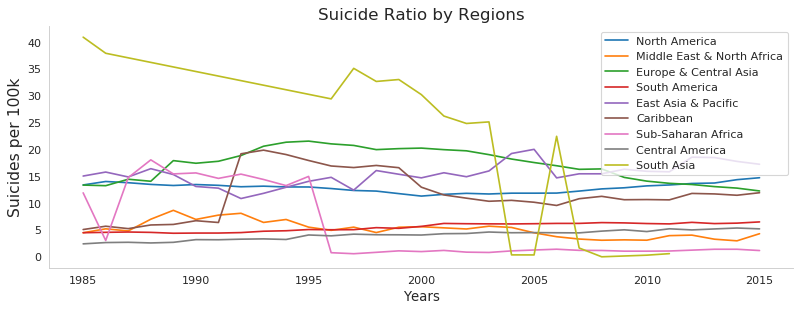

In [16]:
fig, ax = standard_plot('Suicide Ratio by Regions', 'Years', 'Suicides per 100k')

for reg in regions:
    ax.plot('year', 'Suicides per 100k', data=region_data.query("Region == @reg"), label=reg)
    
plt.legend();

Something doesn't feel right on our South Asia data, lol. Lets take a quick detour to analyse it.

In [17]:
years = [1999, 2000, 2004]
dataset.query("Region == 'South Asia'")[aux_cols].groupby(['year', 'country']).agg(agg_dict).loc[years]

population  total_suicides
year country                              
1999 Sri Lanka    17020287            5619
2000 Maldives       247387               0
     Sri Lanka    17140342            5252
2004 Maldives       280526               1

Looks like Maldives' and Sri Lanka's big difference in measures and missing data throughout the years are to blame.<br>
This is just for South Asia but we see quite the variation on a few other Regions that are probably due to change in participating countries. <br>
I will not waste any more of mine and yours time in Regions as I don't believe we can get any value from it alone. 

<hr>


## 2.3 - Countries

#### Countries vs Years
First, let's look at how the number of countries vary along the years

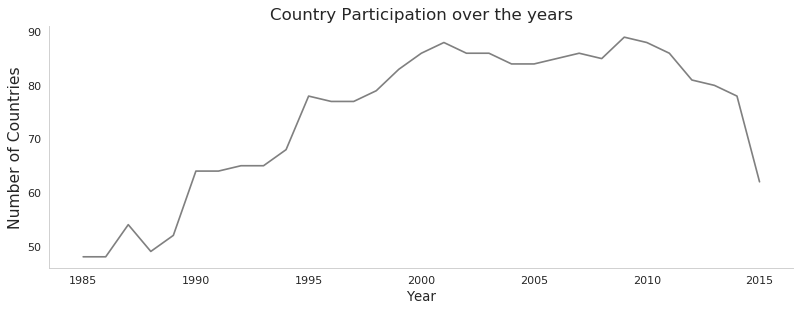

In [18]:
fig, ax = standard_plot('Country Participation over the years')
sns.lineplot(data=yearly_data, x='year', y='country', color='gray', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Countries');

We do have an increase in the number of countries since the beginning of the dataset. We also notice some decrease at the end of it.
<br>What is important to notice, though, is that there is a lot of variation in the number of countries throughout those years.

Now lets group the data by countries

<blockquote>
    <p>
        <font color="darkblue">
            The <b>country_year_range</b> function defined below applies a filter for year range and then groups the data by country. It performs the proper grouping calculation like I commented before.<br>
            It also adds a <i>Years Present</i> column to count the number of years certain country was present in the data.<br>
            Following the coding rule: <i>"If you used it three times, make it a function"</i>
        </font>
    </p>
</blockquote>            

In [19]:
def country_year_range(data, start=None, end=None):
    if (start == None) and (end == None):
        data = data
    
    elif end == None:
        data = data.query('year >= @start')
        
    elif start == None:
        data = data.query('year <= @end')
        
    else:
        year_range = np.arange(start, end+1)
        data = data.query('year in @year_range')
    
    # Aggregating each column properly.
    agg_dict = {'country':'count', 'year':'nunique',
                'total_suicides':'sum', 'population':'sum',}
    df = data[['country', 'year',
               'total_suicides', 'population']].groupby('country').aggregate(agg_dict)

    # Creating our usual feature
    df['Avg. Suicide per 100k'] = df['total_suicides'] * 1e5 / (df['population'])

    df = df.drop(['country', 'total_suicides', 'population'], axis=1)
    df.rename(columns={'year':'Years_Present'}, inplace = True)
    
    return df

In [20]:
# Country data for the whole dataset
country_data = country_year_range(dataset)

# Country data after (and including) 2011
rec_country_data = country_year_range(dataset, start=2011)

### Top 10 countries

<p>The graph plotted below shows a 2 x 2 grid with the highest/lowest suicide rates between countries for all years and for the LAST FIVE YEARS of our dataset.</p>
<p>I have applied filters to include only countries with at least 20 years of data for all years and at least 4 years of data for the last 5 years. (these numbers were chosen arbitrarly to reduce noise from countries with few data points).</p>

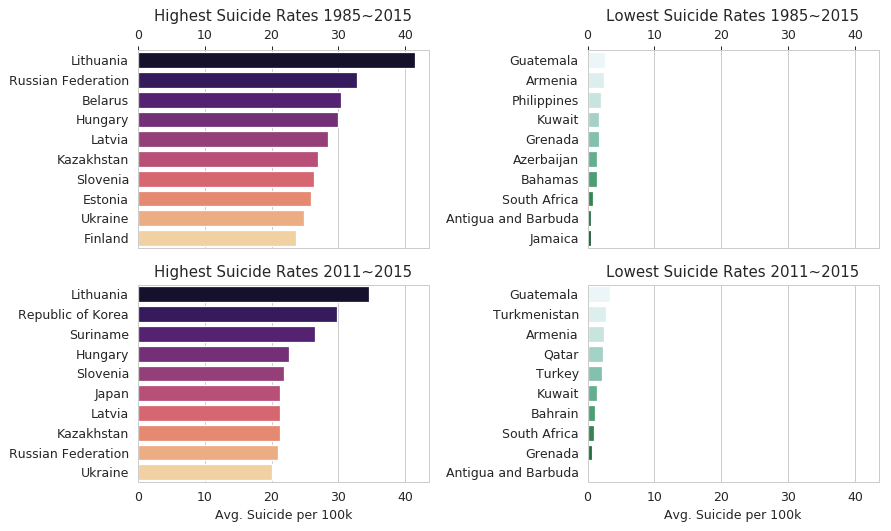

In [21]:
frequent_countries = country_data.sort_values('Avg. Suicide per 100k', ascending=False)
frequent_countries = frequent_countries.query("Years_Present >= 15")

r_frequent_countries = rec_country_data.sort_values('Avg. Suicide per 100k', ascending=False)
r_frequent_countries = r_frequent_countries.query("Years_Present >= 4")


# Defining the 2 x 2 graph grid
fig, (row1, row2) = plt.subplots(2,2, figsize=(10,6), dpi=90, sharex=True)


# FIRST ROW
# Left Graph
row1[0].set_title('Highest Suicide Rates 1985~2015')
sns.barplot(data=frequent_countries[:10], x='Avg. Suicide per 100k',
            y=frequent_countries[:10].index, ax=row1[0], palette='magma')
row1[0].xaxis.label.set_visible(False)
row1[0].yaxis.label.set_visible(False)
row1[0].xaxis.set_ticks_position('top')

# Right Graph
row1[1].set_title('Lowest Suicide Rates 1985~2015')
sns.barplot(data=frequent_countries[-10:], x='Avg. Suicide per 100k',
            y=frequent_countries[-10:].index, ax=row1[1], palette='BuGn')
row1[1].xaxis.label.set_visible(False)
row1[1].yaxis.label.set_visible(False)
row1[1].xaxis.set_ticks_position('top')


# SECOND ROW
# Left Graph
row2[0].set_title('Highest Suicide Rates 2011~2015')
sns.barplot(data=r_frequent_countries[:10], x='Avg. Suicide per 100k',
            y=r_frequent_countries[:10].index, ax=row2[0], palette='magma')
row2[0].yaxis.label.set_visible(False)

# Right Graph
row2[1].set_title('Lowest Suicide Rates 2011~2015')
sns.barplot(data=r_frequent_countries[-10:], x='Avg. Suicide per 100k',
            y=r_frequent_countries[-10:].index, ax=row2[1], palette='BuGn')
row2[1].yaxis.label.set_visible(False)

plt.tight_layout();

<b>Insights from the plot:</b>
<ul>
    <li>Lithuania has the highest numbers in both timeframes;</li>
    <li>Russia had a nice decrease in their numbers the last few years, almost leaving the top 10. Belarus managed to leave the top 10;</li>
    <li>Antigua and Barbuda managed to lower even more its ratio on the last five years.</li></ul>
    
<p>This plot gives us a nice overview of countries and as an idea for a next work we could examine the extremes and try to find which factors are most important there.</p>

<hr>
## 2.4 - The 1995 Increase

<p>To analyse this phenomenon I will gather data from 1995 and from a previous year. I arbitrarly chose to compare it to 1989 by looking at the graph in 3.1.</p> 

    

In [22]:
country_year_gb = dataset.groupby(['country', 'year'],
                                  as_index=False).sum()[['country', 'year',
                                                         'total_suicides', 'population']]

country_year_gb['Suicides_per_100k'] = 1e5 * country_year_gb['total_suicides'] / country_year_gb['population']

nnfive = country_year_gb.query("year in [1989, 1995]").pivot_table(index='country',
                                                                   columns='year',
                                                                   values=['total_suicides',
                                                                           'Suicides_per_100k'],
                                                                   aggfunc='sum')

nnfive['Changes in Number of Suicides'] = (nnfive.iloc[:,3] - nnfive.iloc[:,2])

nnfive.sort_values('Changes in Number of Suicides', ascending=False)[:6]

Suicides_per_100k              ...              Changes in Number of Suicides
year                            1989              ...                                           
country                                           ...                                           
Russian Federation         27.997590              ...                                    22627.0
Ukraine                    22.794415              ...                                     3654.0
Brazil                      3.471252              ...                                     2073.0
Republic of Korea           7.717346              ...                                     1818.0
United States              13.167630              ...                                     1054.0
Mexico                      2.613546              ...                                     1012.0

[6 rows x 5 columns]

<blockquote>
    <p>
        <font color="darkblue">
            <b>How did I arrive in this table?</b> 
            <ol>
                <li>Grouped the data by country and year, summing population and suicides and then calculating the ratio</li>
                <li>Filtered the data for 1989 and 1995 only, and then created a pivot table with those years as different columns</li>
                <li>Ordered the table by the changes in number of suicides descending</li> 
            </ol>
        </font>
    </p>
</blockquote>

The numbers on Russia are impressive. Looks like Russia single-handedly increased the World's suicide average.
<br>Lets see how the same graphs from 3.1 looks without Russia.

In [23]:
# Creating a filtered dataset by removing Russia and calculation our Ratio
without_ru = dataset.query("country != 'Russian Federation'") \
                .groupby('year', as_index=False).sum()

without_ru['Suicides per 100k'] = 1e5 * without_ru['total_suicides']/without_ru['population']

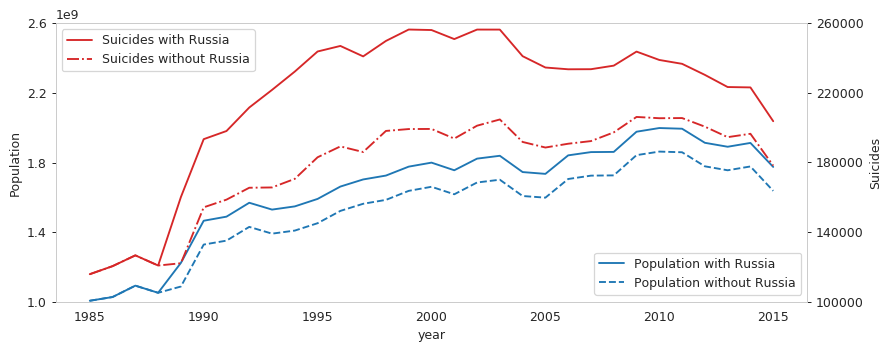

In [24]:
## Primary Axis - Population
# Plotting
fig, ax1 = plt.subplots(1,1,figsize=(10,4), dpi=90, sharey=False)

yearly_data.plot(x='year', y='Population', ax=ax1,
                 label='Population with Russia', c='C0', ls='-')

without_ru.plot(x='year', y='population', ax=ax1,
                    label='Population without Russia', c='C0', ls='--')

# Formatting
ax1.set_ylim(1e9, 2.6e9)
ax1.set_yticks([1e9, 1.4e9, 1.8e9, 2.2e9, 2.6e9])
ax1.grid(False)
ax1.set_ylabel('Population')

## Secondary Axis - Suicides
# Plotting
ax1b = ax1.twinx()
yearly_data.plot(x='year', y='Total Suicides', ax=ax1b, c='C3',
                 ls='-', label='Suicides with Russia')
without_ru.plot(x='year', y='total_suicides', ax=ax1b, c='C3',
                    ls='-.', label='Suicides without Russia')
# Formatting
ax1b.set_ylim(1e5, 2.6e5)
ax1b.grid(False)
ax1b.set_ylabel('Suicides')
ax1b.set_yticks([1e5, 1.4e5, 1.8e5, 2.2e5, 2.6e5])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(1, 0.2));

<blockquote>
    <p>
        <font color="darkblue">
            <b>On the choice of axis limits:</b><br>
            I defined both Y-axis so that both measures have the same relative change and can be better interpreted. In other words, the vertical distance between the dashed line and the solid line mean the same thing in terms of percentage change for both plots. 
            <br>That way we can see that suicide numbers had a larger increase when adding Russia compared to the increase in population, specially between 1995 and 2005. <br>Try measuring it with your finger or some object in your desk!
        </font>
    </p>
</blockquote>

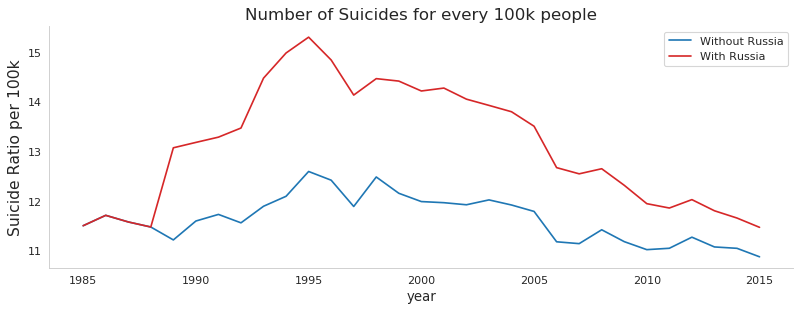

In [25]:
fig, ax = standard_plot('Number of Suicides for every 100k people',
                        'Year', 'Suicide Ratio per 100k')

without_ru.plot(kind='line', x='year', y='Suicides per 100k',
                    ax=ax, label='Without Russia', grid=False)

yearly_data.plot(kind='line', x='year', y='Suicides by 100k people',
                 ax=ax, label='With Russia', c='C3', grid=False);

<p>Ok, that tells us <b>a lot</b>.<br></p>
<p>Apparently Russia has a serious problem on this delicate subject. I come from Brazil and I didn't have a clue on this. <br>Some researchers attribute this to alcooholism (<a href= "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1642767/">link</a>). I will not dive into this as I was totally unaware of this problem up until this analysis.</p>


---

## 2.5 - Demographic Groups (Gender and Age)

Now that we are done with countries and years, let's look at demographic groups.<br>
We have a total of 12 demographic groups in which our coutries' population is divided.<br>
Lets have a broader look on how these differ in suicide rates

In [26]:
# Replacing the first age group values so the libraries can order it alfabetically 
dataset.age = dataset.age.replace({'5-14 years':'05-14 years'})

<blockquote>
    <p>
        <font color="darkblue">
            The function defined in the cell below simply groups the data properly for a heatmap and applies a country filter. <br>I was having to repeat it a lot so just stopped being lazy and made the function.
        </font>
    </p>
</blockquote>

In [27]:
# Again, just following the rule: 'If you used it three times, make it a function'
def demographic_country_filter(data, keep=None, remove=None):
    
    agg_dict = {'year':'nunique', 'population':'sum', 'total_suicides':'sum'}
    
    if keep == remove:
        # Means no country filters are being passed
        data = data.pivot_table(values=['total_suicides', 'population'],
                                index='age', columns='sex', aggfunc='sum')
        data['Avg Suicides','male'] = 1e5*data['total_suicides','male']/data['population','male']
        data['Avg Suicides','female'] = 1e5*data['total_suicides','female']/data['population','female']        
        return data

    elif keep != None:
        countries_list = keep
        data = data.query("country in @countries_list") \
                   .pivot_table(values=['total_suicides', 'population'], 
                                index='age', columns='sex', aggfunc='sum')
        
        data['Avg Suicides','male'] = 1e5*data['total_suicides','male']/data['population','male']
        data['Avg Suicides','female'] = 1e5*data['total_suicides','female']/data['population','female']
        return data
    
    else:
        exclude_list = remove
        data = data.query("country not in @exclude_list") \
                   .pivot_table(values=['total_suicides', 'population'], 
                                index='age', columns='sex', aggfunc='sum')
        
        data['Avg Suicides','male'] = 1e5*data['total_suicides','male']/data['population','male']
        data['Avg Suicides','female'] = 1e5*data['total_suicides','female']/data['population','female']
        return data

In [28]:
# Creating the data for all countries
demo_all = demographic_country_filter(dataset)

# Creating the data for Brazil
demo_brazil = demographic_country_filter(dataset, keep='Brazil')

# Picking random country
countries_all_years = country_data.query("Years_Present == 31").index
rand_country = countries_all_years[np.random.randint(0, 23)]
demo_random = demographic_country_filter(dataset, keep=rand_country)

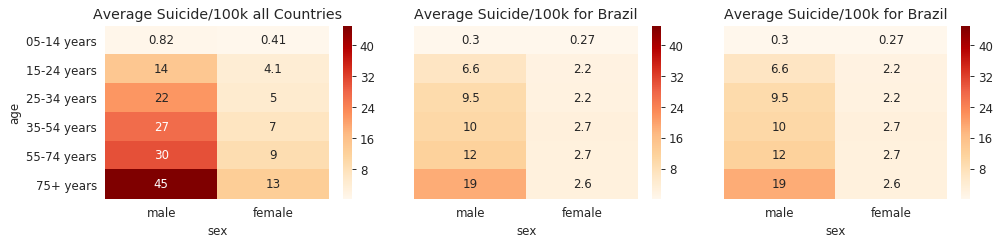

In [29]:
fig, axes = plt.subplots(1,3, figsize=(12,3), dpi=85, sharey=True)

# Left plot, World-data
sns.heatmap(data=demo_all['Avg Suicides'], annot=True, ax=axes[0], vmax=45, cmap='OrRd')
axes[0].set_title('Average Suicide/100k all Countries');

# Middle plot, Brazil 
sns.heatmap(data=demo_brazil['Avg Suicides'], annot=True, ax=axes[1], vmax=45, cmap='OrRd')
axes[1].yaxis.label.set_visible(False)
axes[1].set_title('Average Suicide/100k for Brazil')

# Right plot, random country present in all years
sns.heatmap(data=demo_random['Avg Suicides'], annot=True, ax=axes[2], vmax=45, cmap='OrRd')
axes[2].yaxis.label.set_visible(False)
axes[2].set_title(f'Average Suicide/100k for {rand_country}')

plt.tight_layout();

<blockquote>
    <p>
        <font color="darkblue">
            This plot shows the suicide rating on three different populations. 
            <ol>
                <li>Worldwide</li>
                <li>Only Brazil</li>
                <li><b>Random Country</b></li>
            </ol>
            I chose to pick a random country from a list to illustrate what I mentioned before: <u>these measures are strongly related to a specific culture and society.</u> <br>
            At the moment I am writing this, I got Mexico. It differs from the other two plots quite a lot. For example: the values for male decrease in age 35-54 years and females have a maximum value at 15-24 years.
        </font>
    </p>
    </blockquote>

#### Insights and comments:
- The thing that stands out more is that SR tends to increase with age and that males have higher numbers than females. This seem to be the same for all countries in the data (I have not looked all of them); 
- In my social and cultural context, news often depict young people comitting suicide and I've never heard a case of someone 75+. Perhaps people are less discrete with younger victims;
- In the first two graphs we see similar increasing behavior (Brazil and Worldwide) on males (e.g. the numbers in 75+ years are roughy two times the 25-34 years ratio);
- Women in Brazil behave differently than the world-data. The ratio does not increase much with age. In fact, at 75+ years it has a slight decrease.

---

## 2.6 - Generation

Generation depends on the year the person was born. This info can be infered with the age group of the person plus the year of the data point.

The generations are divided as follows:

|     Generation    |  Birth Range | Avg. Age Today |
|:-----------------:|:------------:|:--------------:|
|  G.I. Generation  | 1910 to 1924 |       102      |
| Silent Generation | 1925 to 1945 |       84       |
|    Baby Boomer    | 1946 to 1964 |       64       |
|    Generation X   | 1965 to 1979 |       47       |
|     Millenials    | 1980 to 1994 |       32       |
|    Generation Z   | 1995 to 2012 |       17       |

Source: https://www.careerplanner.com/Career-Articles/Generations.cfm

I will just plot them all across the years to have a first look.

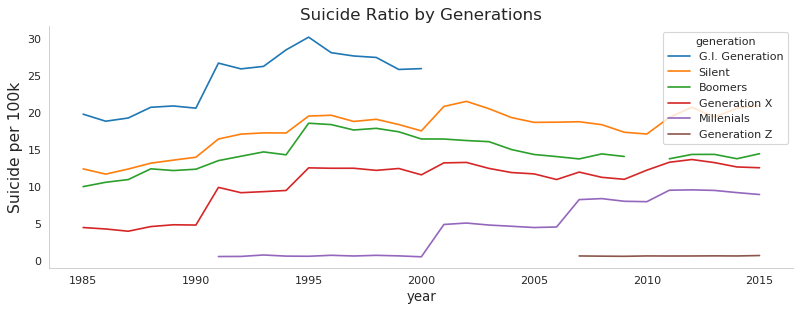

In [30]:
fig, ax = standard_plot('Suicide Ratio by Generations', 'Year', 'Suicide per 100k')
gen_data = dataset.pivot_table(values='suicides_per_100k', index='year',
                    columns='generation', aggfunc='mean')
gen_data = gen_data[['G.I. Generation', 'Silent', 'Boomers',
                     'Generation X', 'Millenials', 'Generation Z']]
gen_data.plot(ax=ax, grid=False);

**Insights from graph:**
- There are some sudden increases due to our data's populations changing between generations;
- We can see an overall trend of increase with time;
- This, however, can be attributed simply to an increase with **age**. Generations are not a strong and univesal concept and might provide no information - or even mislead us. 

That said, we will not go further in analyzing generations.

---

---
# 3 - What about money??

<blockquote>
    <p>
        <font color="darkblue">
            This section will be a bit more dense but it is probably the most interesting one. I will intentionally plot some confusing graphs so you can understand my thought process. I will redirect your attention before each graph so you don't get lost and waste too much time in the plots.<br><br>
            Please bear with me while I dive into this feature, I believe you'll find it interesting.
        </font>
    </p>
</blockquote>
    
GDP and HDI are values for a country - year combination, so lets create a dataset accordingly.    

In [31]:
# Getting the sums (population and suicides)
gdp_hdi_sums = dataset[['country', 'year', 'population',
                        'total_suicides']].groupby(['country', 'year'], as_index=False).sum()

# Getting the GDP and HDI values
gdp_hdi_avgs = dataset[['country', 'year', 'gdp_per_capita',
                        'HDI_for_year']].groupby(['country', 'year'], as_index=False).mean()

# Joining both
gdp_hdi = pd.concat([gdp_hdi_avgs, gdp_hdi_sums[['population', 'total_suicides']]], axis=1)

# Adding information for Regions
gdp_hdi['Region'] = gdp_hdi.merge(countries_lookup, on='country', how='left')['Region']

# Calculation the Suicide Ration
gdp_hdi['Avg Suicides per 100k'] = 1e5 * gdp_hdi['total_suicides'] / gdp_hdi['population']

---

## 3.1 - First Confusing Graph
<p>OK here we go.</p>
<p>
    The graph below is a scatter plot for GDP per capita and SR (Suicide Ratio per 100k) plotted in a LOG scale. I chose to pick only the countries present in all years to not overclutter this visualization. (list <i>countries_all_years</i>). 
    <br>The First thing you will notice is: This is a mess.
</p> 
<p>
    Well, <b>that's the POINT.</b>
</p>
<p>
    We see countries' SR going up, going down and going crazy with changes in GDP. So, is money good or bad??
</p>

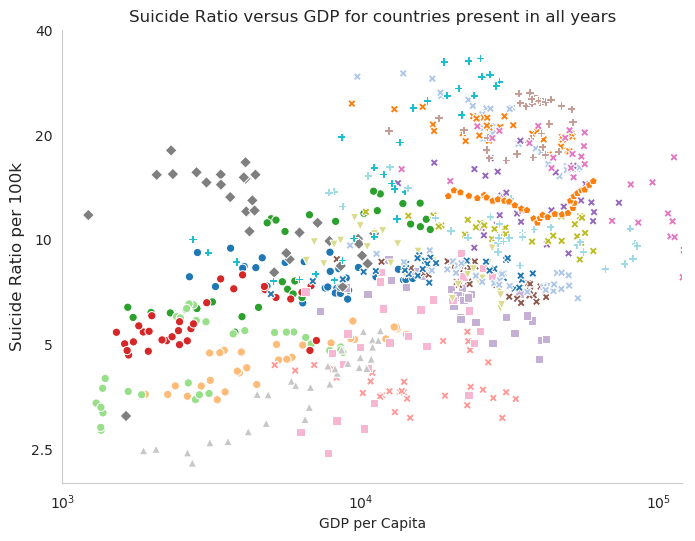

In [32]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.scatterplot(data=gdp_hdi.query("country in @countries_all_years"), x='gdp_per_capita', style='Region',
                y='Avg Suicides per 100k', hue='country', palette='tab20', ax=ax)
plt.legend().set_visible(False) #(bbox_to_anchor=[1, 1], prop={'size':7})

# Dealing with the scale
ax.set_xlim(1e3, 12e4)
ax.set(xscale="log", yscale="log")
ax.set_ylim(bottom=2, top=30)
ax.set_yticks([2.5, 5, 10, 20, 40])
ax.set_yticklabels([2.5, 5, 10, 20, 40])

# Formatting
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(12)
ax.title.set_fontsize(13)
ax.grid(False)

# Naming stuff
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Suicide Ratio per 100k')
ax.set_title('Suicide Ratio versus GDP for countries present in all years');

**There are quite a few things I would like to mention**:
- As I already mentioned. It is a mess. I intentionally hid the legend because I don't want to look at each country just yet;
- Some countries do show a positive correlation, some show a negative correlation and some look just random.;
- Money alone is definitely not a factor (we wouldn't have opposite effects otherwise). We can also say that those *apparent correlations* are most likely **not causations**.
- It looks like the countries in our plot mostly reside in two quadrants, Low SR/GDP and High SR/GDP. 
- On top of that, countries that are in the 'Low Quadrant' seem to have a positive correlation with GDP, while the countries in the 'High Quadrant' don't.

Well, this is still too messy. I'll try to reframe the data to try and highlight what I am saying here. 

<blockquote>
    <p>
        <font color="darkblue">
            <b>Correlation vs Causation</b><br><br>
            I believe it is worth to mention this in this context so we don't get any confused (I'm pretty confused already).
            <br><br>Lets borrow the (famous?) ice-cream example for a moment: 
            Imagine if you plotted Ice-cream Sales vs Shark Attacks. 
            You would probably get a positive correlation and it is quite intuitive: <b>both increase in the summer</b>. This is a clear example of two measures that <b>have correlation</b> but <b>don't have causation</b>. I think we all agree that Ice-creams aren't shark magnets.<br><br>
        Comparing to our case, it would be like if ice-creams sales increased shark attacks in some countries and decreased in others. Another link to our analysis is that GDP increases with time for most countries (it's easy to see that on this dataset). Both may have a correlation without causation.<br><br>
        This emphasizes how GDP is definitely not a cause to SR and how simple is our analysis compared to the complexity of the problem.
        </font>
    </p>
</blockquote>

---

## 3.2 - Second Confusing Graph
This one is a little bit less confusing and things will start to untangle.

For this seccond attempt on digging GDP I will calculate the correlation between GDP and SR for each country in our dataset for all years and save into a dataframe.

<blockquote>
    <p>
        <font color="darkblue">
            <b>Coding Explanation!</b><br>
            The cell below uses the following steps to obtain the correlations:
            <ol>
                <li>Iterates through every country which has atleast 15 data points, filters the data on that country and saves it under <i>temp_data</i></li>
                <li>Filters GDP and SR columns and calculates the correlation using the .corr() method</li>
                <li>Stores the correlation in a list to later add it in a dataframe with every Country and Region</li>
            </ol>
        </font>
    </p>
</blockquote>


In [33]:
atleast_15 = gdp_hdi.country.value_counts()[:84].index
gdp_atleast15 = gdp_hdi.query("country in @atleast_15")

correlations = []

for ctr in atleast_15:
    temp_data = gdp_atleast15.query("country == @ctr")
    correlations.append(temp_data[['gdp_per_capita', 'Avg Suicides per 100k']].corr().iloc[0, 1])

correlations = np.array(correlations)

country_corr = pd.DataFrame({'country':atleast_15, 'GDP-Suicide Correlation':correlations})
country_corr = country_corr.merge(countries_lookup, on='country', how='left').dropna()

<blockquote>
    <font color="darkblue">
        This next cell is just about formatting the plot.
    </font>
</blockquote>    

In [34]:
s_a   = gdp_atleast15.query("Region == 'South America'").country.unique()
c_a   = gdp_atleast15.query("Region == 'Central America'").country.unique()
car   = gdp_atleast15.query("Region == 'Caribbean'").country.unique()
n_a   = gdp_atleast15.query("Region == 'North America'").country.unique()
eu_ca = gdp_atleast15.query("Region == 'Europe & Central Asia'").country.unique()
ea_pa = gdp_atleast15.query("Region == 'East Asia & Pacific'").country.unique()
me_na = gdp_atleast15.query("Region == 'Middle East & North Africa'").country.unique()
ss_a  = gdp_atleast15.query("Region == 'Sub-Saharan Africa'").country.unique()
# South Asia has no country present in this 15 years filter
#s_as  = gdp_atleast15.query("Region == 'South Asia'").country.unique()

region_order = np.concatenate([s_a, c_a, car, n_a, eu_ca,
                               ea_pa, me_na, ss_a]) #, s_as])
hue_order = ['South America', 'Central America',  'Caribbean', 
             'North America', 'Europe & Central Asia',
             'East Asia & Pacific', 'Middle East & North Africa',
             'Sub-Saharan Africa'] #,'South Asia']

This second graph will list all countries, colored by region, and plot a horizontal bar which corresponds to its SR-GDP correlation. What do you see here?

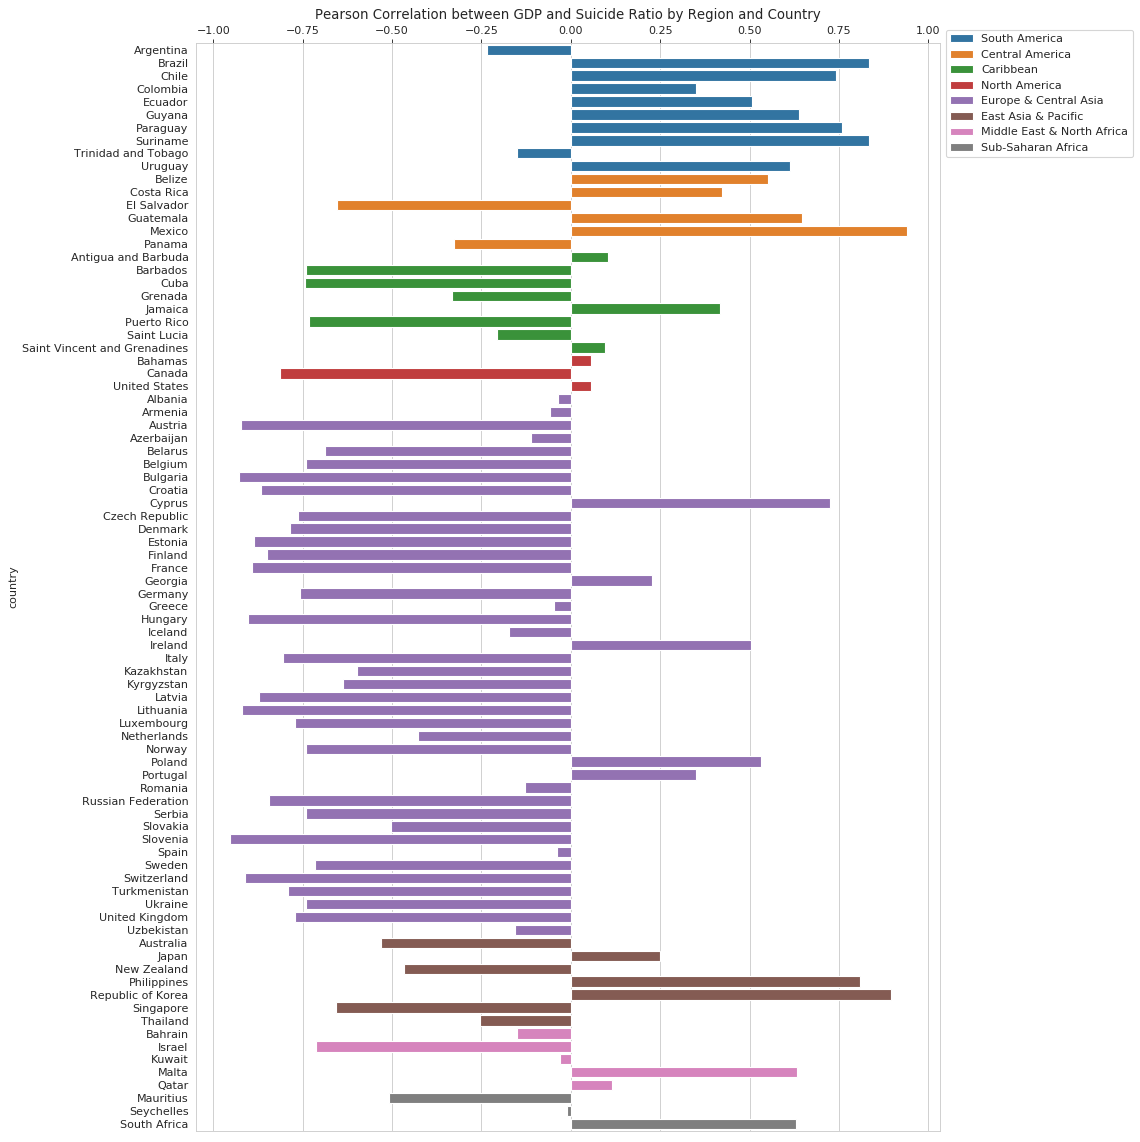

In [35]:
fig, ax = plt.subplots(figsize=(12,18), dpi=80)
sns.barplot(data=country_corr, y='country', x='GDP-Suicide Correlation',
            hue='Region', dodge=False, palette='tab10',
            order=region_order, hue_order=hue_order)

ax.set_title('Pearson Correlation between GDP and Suicide Ratio by Region and Country')
ax.xaxis.tick_top()
ax.xaxis.label.set_visible(False)
ax.legend(bbox_to_anchor=[1.0, 0.89]);

### Insights:
- First, plotting like this makes it much clearer on how GDP is NOT an universal factor on suicide. Look at how the bars size and direction change!
- Making this distinction by regions has its ups and downs. For the last three regions and for North America the number of countries is small so I would advise against trying to derive any conclusions from it.
- However, we have some things to talk about on Europe and America. But before we get into those, please remember that trends change with time and we are looking at a 30 years time period. We will get back into that in a moment.

### Regions:
- In the previous plot I talked about the **LOW SR/GDP** quadrant and the **HIGH SR/GDP** quadrant and how the 'looked' like had opposite effects (increase and decrease with GDP, respectively). This plot allows us to visualize it better. 
- Europe (the HIGH quadrant) has a majority of countries that have negative correlations, while South America and Central America (LOW quadrant) has a majority of positive correlations. 
- The Caribbean islands have more negative correlations. 
- The big difference between Canada and the US is quite interesting, but I will not dive into that either.

<blockquote>
    <font color="darkblue">The more time I spend in this dataset the more I feel like living in a tropical island seems like a good idea</font>
</blockquote>

---

## 3.3 - SR and GDP over the years

As I just mentioned, trends change over time. We will expose that using Korea, the UK, Malta, the US and Russia as an example.  

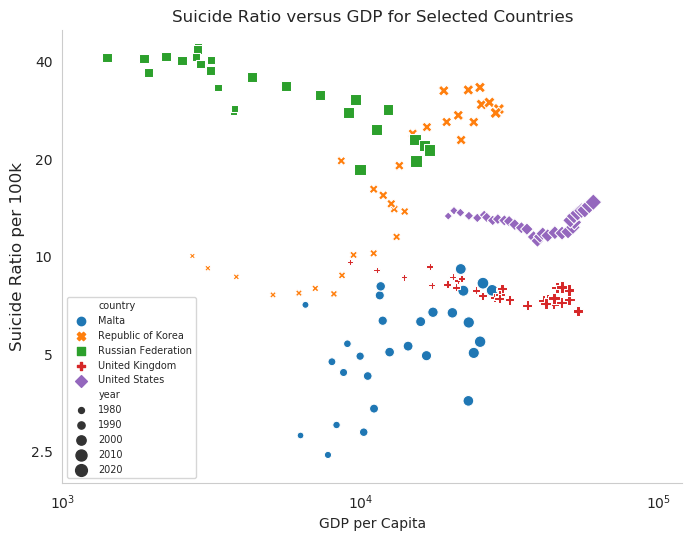

In [36]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
another_fn_list = ['Republic of Korea', 'United Kingdom',
                   'Malta', 'United States', 'Russian Federation']

sns.scatterplot(data=gdp_hdi.query("country in @another_fn_list"),
                x='gdp_per_capita', style='country',
                y='Avg Suicides per 100k', size='year',
                ax=ax, hue='country', palette='tab10')

plt.legend(prop={'size':7}).set_visible(True)

# Dealing with the scale
ax.set_xlim(1e3, 12e4)
ax.set(xscale="log", yscale="log")
ax.set_ylim(bottom=2, top=50)
ax.set_yticks([2.5, 5, 10, 20, 40])
ax.set_yticklabels([2.5, 5, 10, 20, 40])

# Formatting
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(12)
ax.title.set_fontsize(13)
ax.grid(False)

# Naming stuff
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Suicide Ratio per 100k')
ax.set_title('Suicide Ratio versus GDP for Selected Countries');

#### Insights from the plot:
- We again see clearly that countries behave quite differently AND change with time;
- Korea has a worrying trend and Malta seem quite random;
- There is an inflection point in the US, I wonder if it is related to the 2008 crysis;
- Russia is definitely lowering their numbers (from ~40 to ~20). It has an interesting behavior as well if you look at the time evolution of SR and GDP (going 'up-left' then 'down-right')  

---

## 4.4 Final Thoughts on Money

In this section I will summarize the findings in the previous plots about GDP and give my **personal opinion** on them.

**A: Does money matter?**
<p><font color='green'><b>Data</b>: As we've seen in all plots on this section, money has no clear influence on suicide ratios. The correlations are definitely not causation. <br></font></p>

<p><font color='darkcyan'><b>Personal Opinion</b>: Our brain goes back to millions of years. We've lived most of that time without money. Our brain knows how to be happy without money and its chemical processes don't need a bank account to work perfectly fine. However, I do believe money might lead to suicide when people live by and for it. When your happiness depends on your money and it suddently goes away, or when your life is about getting money and when you finally do, you find no meaning in it. Sure, those things can happen, but that is not about money, that is about culture and beliefs.</font></p>  

**B: The Lower Quadrant**
<p><font color='green'><b>Data:</b> We've identified this pattern in the two confusing graphs presented in this section. Countries in this quadrant seem to have a positive correlation between SR and GDP.<br></font></p>

<p><font color='darkcyan'><b>Personal Opinion</b>: I can think of two possible things to attribute this behavior: People are getting older and Disconnection.
    <ol>
        <li>People are getting older: This is just looking at the plot presented on demographic groups: older people have higher suicide ratios and this is a trend. It has been observed in other countries that as GDP, Education and other factors increase, the birth rates decrease and the population shifts towards an inverse pyramid (older people in a bigger share).</li>
        <li>Disconnection: This one is more subtle and perhaps controversial opinion. As these younger countries in the lower quadrant 'grow', more people get in touch with first-world things, such as habits and devices. The more we connect in instagram and facebook, **the more we disconnect to our non-digital lives and communities**. You might have a different opinion on this digital society we live in and say that it helps some people. I believe it does, but looking at the whole picture, does it helps us as a species? You must agree that unlike money, we have lived in close intimate communities and had close and intimate relationships for millions of years. And the data dont lie. Such developing countries or countries that don't have that much technology imbued in its culture have lower suicide ratios. This epidemy of anxiety and depression are a 21st century thing. As is the internet.</li>
    </ol>
    </font></p>
    
<blockquote><font color="darkblue">Please note that I am not saying technology is a bad thing. I personally love technology but I'm <b>just saying that it's not just flowers</b>.</font></blockquote>


**C: The Higher Quadrant**

<p><font color='green'><b>Data</b>: Similar to the lower quadrant but in opposite direction, this quadrant was identified to be mostly Europe countries with a negative SR and GDP correlation. <br></font></p>

<p><font color='darkcyan'><b>Personal Opinion</b>: I don't have any strong opinions which I believe might be the cause for it. Is it a cultural change happening over the years? I would appreciate if someone within this quadrant can give us some insight on what might be this cause. </font></p>

---

---

# 4 - Religions and Sun Exposure
Many ideas pop up while studying this topic. I eventually have to choose something and follow that path. However, in this chapter I will quickly explore some other features that might be related to suicide.

I will not dive deeply on it nor make any conclusions. The idea of this chapter is to use other data to inspire and incite a further analysis on suicides. 

<hr>
## 4.1 - Religion and Suicide

I have downloaded some data from data.world.com ([link](https://data.world/cow/world-religion-data)) about religion populations around the world and processed it to plot the graph below. I do not do the processing here. The data added is already processed and ready for plotting.

In [37]:
country_religion_data = pd.read_csv('../input/religions-lookup/religions_lookup.csv')

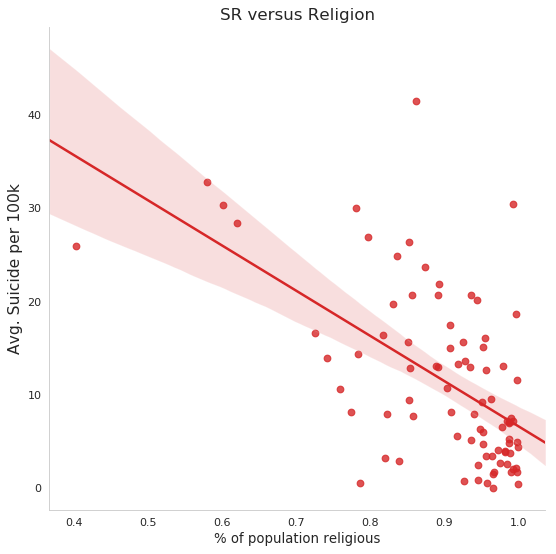

In [38]:
religion_data = country_data.merge(country_religion_data,
                                   left_index=True,
                                   right_on='country',
                                   how='left')

fig, ax = standard_plot('SR versus Religion', '% of population religious', 'SR')
fig.set_size_inches(8,8)
sns.regplot(data = religion_data, x='Religious Percent',
              y='Avg. Suicide per 100k', ax=ax, color='C3')
ax.set_xlabel('% of population religious');

**Insights**:
- It seems like religion does play a role on it, which makes sense. Independent of which god you believe in, religion is attached to a sense of community and I just presented my thoughts on how I think community is important to us;
- However, being religious apparently can only get you so far and you would need something else to lower the SR;
- The data I mentioned before the graph has information on all major religions. Analyzing which religions impact suicide ratios the most is a good place to start.

---

## 4.2 - Sun Exposure

One can argue that temperature is related to sun exposure, sun exposure is related to Vitamin D and Vitamin D has been studied as a factor related to mental health and depression ([link](https://examine.com/nutrition/vitamin-d-and-depression/))

One can also argue that sun exposure is related to Melatonin, Melatonin is related to sleep quality and sleep quality is related to mental health ([link](https://www.sleepfoundation.org/excessive-sleepiness/health-impact/complex-relationship-between-sleep-depression-anxiety))

That's why I decided to briefly explore these two factors together. Let's see what our data tells us.

The data I use was obtained on [kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data#GlobalLandTemperaturesByMajorCity.csv) and has already been processed and filtered to only show data by year and countries included in our suicide data. 

In [39]:
country_year_temperature_data = pd.read_csv('../input/temperature-by-country-and-year/temperature_data.csv')
country_temperature_data = country_year_temperature_data.groupby('country').mean()

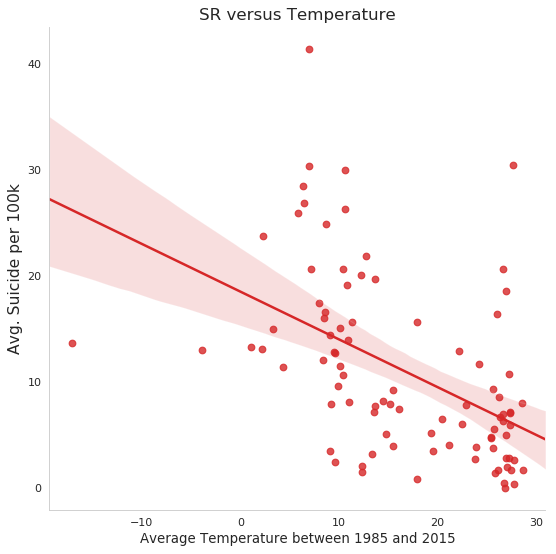

In [40]:
temperature_data = country_data.merge(country_temperature_data,
                                      left_index=True,
                                      right_on='country',
                                      how='left')

fig, ax = standard_plot('SR versus Temperature', 'Average Temperature', 'SR')
fig.set_size_inches(8,8)
sns.regplot(data = temperature_data, x='avg_temp',
              y='Avg. Suicide per 100k', ax=ax, color='C3')
ax.set_xlabel('Average Temperature between 1985 and 2015');

<hr>
## 4.3 - Praise the Sun!

![](https://cdn.gamerant.com/wp-content/uploads/dark-souls-3-solaire-astora-figure.jpg.optimal.jpg)

We can create a 2D map with those two features and plot all countries in it. I built using Tableau and you can check each point for details. 

It definitely looks that for the countries in our data religion and average temperature play a role!

In [41]:
%%HTML
<div class='tableauPlaceholder' id='viz1561887580533' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TempRelig&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TempRelig&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TempRelig&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1561887580533');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='727px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

---

---

# 5 - Country Dashboard

This dashboard was built with the data used in this analysis and using Tableau. **How is your country doing??**

In [42]:
%%HTML
<div class='tableauPlaceholder' id='viz1561735467494' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Su&#47;Suicide_ratio_Dashboard&#47;SuicidebyCountry&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Suicide_ratio_Dashboard&#47;SuicidebyCountry' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Su&#47;Suicide_ratio_Dashboard&#47;SuicidebyCountry&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1561735467494');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

---

---

# 7. Conclusion

In **Chapter 1** we started introducing this study and reading the data in.

In **Chapter Two**, exploring our data, we've found some interesting information:
- Year 2016 looks incomplete so we removed it from the analysis (chapter 3.1)
- Regions alone did not bring any information (chapter 3.2)
- Not all countries are present, which limits our analysis a lot (chapter 3.3)
- We have plotted a highest and lowest rates for all countries (chapter 3.3)
- The peak in 1995 was due to increase in suicides in Russia (chapter 3.4)
- Older male have an overall higher SR. However, these vary a lot for each individual country (chapter 3.5)
- We've decided not to analyse Generation due to its subjectivity (not sure if this is a word) (chapter 3.6)

In **Chapter Three** GDP's effect on suicides was explored. We've seen that GDP and SR correlation varies a lot for each individual country and we've concluded that this was not a causation.
We've also highlighted two distinct clusters (named quadrants in the analysis) in our data that had opposite correlations between GDP and SR. On 4.3 I discuss why I believe GDP alone is not an important factor and give my opinion on the quadrants.

**Chapter Four** briefly explores and discusses how two other features can influence suicide - religion and temperature.

Finally, **Chapter Five** presents an interactive dashboard to explore these measures on different countries. 

Leave your thoughts or questions in the comments. Any feedback is welcome.

I hope you've enjoyed this study! If you did, please upvote!